In [1]:
!pip install memory_profiler


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import euclidean

class LSH_KNN:
    def __init__(self, n_hash_tables=5, hash_size=10, k=3):
        self.n_hash_tables = n_hash_tables  # Number of hash tables
        self.hash_size = hash_size          # Number of bits in the hash
        self.k = k                          # Number of neighbors
        self.tables = [defaultdict(list) for _ in range(n_hash_tables)]  # Hash tables
        self.projections = []               # Random projections for hash functions

    def _hash_function(self, v, projection):
        """Create a binary hash for vector v using random projection."""
        return tuple((v @ projection > 0).astype(int))  # Binary hash as tuple

    def _generate_projections(self, dim):
        """Generate random projections for each hash table."""
        self.projections = [np.random.randn(dim, self.hash_size) for _ in range(self.n_hash_tables)]

    def fit(self, X, y):
        """Fit LSH to the data."""
        n_samples, n_features = X.shape
        self._generate_projections(n_features)

        # Create hash tables
        for idx, x in enumerate(X):
            for i in range(self.n_hash_tables):
                projection = self.projections[i]
                hash_key = self._hash_function(x, projection)
                self.tables[i][hash_key].append(idx)  # Store index of data point

        self.data = X  # Store the data for later use
        self.labels = y

    def _get_candidates(self, x):
        """Get candidate points for a query point x by checking all hash tables."""
        candidates = set()
        for i in range(self.n_hash_tables):
            projection = self.projections[i]
            hash_key = self._hash_function(x, projection)
            candidates.update(self.tables[i][hash_key])  # Collect indices from each table
        return list(candidates)

    def _get_nearest_neighbors(self, x):
        """Compute nearest neighbors from candidates."""
        candidates = self._get_candidates(x)
        if len(candidates) == 0:
            return []  # No candidates found

        distances = [(i, euclidean(x, self.data[i])) for i in candidates]
        distances.sort(key=lambda x: x[1])  # Sort by distance

        # Return the top-k closest points
        return [idx for idx, dist in distances[:self.k]]

    def predict(self, X):
        """Predict neighbors for each point in X."""
        neighbors = [self._get_nearest_neighbors(x) for x in X]
        return neighbors


In [11]:
from math import sqrt

class KDTreeNode:
    """Node of a KD-tree."""
    def __init__(self, point, axis, left=None, right=None):
        self.point = point     # The point stored at this node
        self.axis = axis       # Axis of splitting
        self.left = left       # Left subtree
        self.right = right     # Right subtree

class KDTreeKNN:
    def __init__(self, k=3):
        self.k = k
        self.root = None

    def _build_tree(self, points, depth=0):
        """Recursive function to build KD-tree."""
        if len(points) == 0:
            return None

        # Select axis based on depth
        axis = depth % points.shape[1]

        # Sort points and choose median
        points = points[points[:, axis].argsort()]
        median_idx = len(points) // 2

        # Create node and recursively construct subtrees
        return KDTreeNode(
            point=points[median_idx],
            axis=axis,
            left=self._build_tree(points[:median_idx], depth + 1),
            right=self._build_tree(points[median_idx + 1:], depth + 1)
        )

    def fit(self, X, y):
        """Fit KD-tree to the data."""
        self.root = self._build_tree(X)
        self.data = X
        self.labels = y

    def _distance(self, point1, point2):
        """Compute Euclidean distance between two points."""
        return sqrt(np.sum((point1 - point2) ** 2))

    def _knn_search(self, node, point, k_neighbors, depth=0):
        """Recursive function to search for k-nearest neighbors."""
        if node is None:
            return
        
        # Skip the test point itself (avoid considering it as its own neighbor)
        if np.array_equal(node.point, point):
            return

        # Compute distance to current node
        dist = self._distance(point, node.point)

        # Update k nearest neighbors
        if len(k_neighbors) < self.k or dist < k_neighbors[-1][1]:
            k_neighbors.append((node.point, dist))
            k_neighbors.sort(key=lambda x: x[1])  # Sort by distance
            if len(k_neighbors) > self.k:
                k_neighbors.pop()  # Keep only k neighbors

        # Determine which branch to search
        axis = node.axis
        diff = point[axis] - node.point[axis]
        next_branch = node.left if diff < 0 else node.right
        opposite_branch = node.right if diff < 0 else node.left

        # Search next branch
        self._knn_search(next_branch, point, k_neighbors, depth + 1)

        # Search opposite branch if necessary
        if len(k_neighbors) < self.k or abs(diff) < k_neighbors[-1][1]:
            self._knn_search(opposite_branch, point, k_neighbors, depth + 1)

    def predict(self, X):
        """Predict k-nearest neighbors for each point in X."""
        neighbors = []
        for x in X:
            k_neighbors = []
            self._knn_search(self.root, x, k_neighbors)
            neighbors.append([neighbor[0] for neighbor in k_neighbors])
        return neighbors


In [4]:
from collections import Counter
from scipy.spatial.distance import euclidean

class NaiveKNN:
    def __init__(self, k=3):
        self.k = k  # Number of nearest neighbors

    def fit(self, X, y):
        """Fit the model using training data."""
        self.X_train = X  # Training data
        self.y_train = y  # Training labels

    def _get_nearest_neighbors(self, x):
        """Find k-nearest neighbors for a single query point."""
        distances = [euclidean(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]  # Get indices of k closest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return k_nearest_labels

    def predict(self, X):
        """Predict the label for each point in X."""
        predictions = []
        for x in X:
            k_nearest_labels = self._get_nearest_neighbors(x)
            most_common = Counter(k_nearest_labels).most_common(1)  # Majority voting
            predictions.append(most_common[0][0])
        return predictions


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import time
from memory_profiler import memory_usage

# Assuming KNN_LSH, KDTreeKNN, NaiveKNN classes are defined as previously provided

# Function to create a synthetic dataset
def generate_data(n_samples, n_features):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42)
    return X, y

# Function to measure training and testing time, and memory usage
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Measuring memory usage and time
    exec_time_train, exec_time_test = [], []

    # Training
    def wrapper_train():
        start_time = time.time()
        model.fit(X_train, y_train)
        exec_time_train.append(time.time() - start_time)

    train_memory = memory_usage(wrapper_train, max_usage=True)

    # Prediction
    def wrapper_test():
        start_time = time.time()
        model.predict(X_test)
        exec_time_test.append(time.time() - start_time)

    test_memory = memory_usage(wrapper_test, max_usage=True)

    return np.mean(exec_time_train), np.mean(exec_time_test), train_memory, test_memory

# List of dataset sizes and dimensions
dataset_sizes = [100, 1000, 10000]
dimensions = [10, 20, 30]

results = []

# Loop through each combination of dataset size and dimensions
for n_samples, n_features in zip(dataset_sizes, dimensions):
    print(f"Evaluating for dataset size {n_samples} and {n_features} features")

    # Generate synthetic data
    X, y = generate_data(n_samples, n_features)

    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    knn_lsh = LSH_KNN(k=5)
    knn_kdtree = KDTreeKNN(k=5)
    naive_knn = NaiveKNN(k=5)

    # Evaluate KNN with LSH
    print("Evaluating KNN with LSH...")
    time_train_lsh, time_test_lsh, mem_train_lsh, mem_test_lsh = evaluate_model(knn_lsh, X_train, y_train, X_test, y_test)

    # Evaluate KNN with KD-Tree
    print("Evaluating KNN with KD-Tree...")
    time_train_kdtree, time_test_kdtree, mem_train_kdtree, mem_test_kdtree = evaluate_model(knn_kdtree, X_train, y_train, X_test, y_test)

    # Evaluate Naive KNN
    print("Evaluating Naive KNN...")
    time_train_naive, time_test_naive, mem_train_naive, mem_test_naive = evaluate_model(naive_knn, X_train, y_train, X_test, y_test)

    # Store results
    results.append({
        'dataset_size': n_samples,
        'dimensions': n_features,
        'KNN_LSH_train_time': time_train_lsh,
        'KNN_LSH_test_time': time_test_lsh,
        'KNN_LSH_train_memory': mem_train_lsh,
        'KNN_LSH_test_memory': mem_test_lsh,
        'KNN_KDTree_train_time': time_train_kdtree,
        'KNN_KDTree_test_time': time_test_kdtree,
        'KNN_KDTree_train_memory': mem_train_kdtree,
        'KNN_KDTree_test_memory': mem_test_kdtree,
        'NaiveKNN_train_time': time_train_naive,
        'NaiveKNN_test_time': time_test_naive,
        'NaiveKNN_train_memory': mem_train_naive,
        'NaiveKNN_test_memory': mem_test_naive
    })

# Display the results in a readable format
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


Evaluating for dataset size 100 and 10 features
Evaluating KNN with LSH...
Evaluating KNN with KD-Tree...
Evaluating Naive KNN...
Evaluating for dataset size 1000 and 20 features
Evaluating KNN with LSH...
Evaluating KNN with KD-Tree...
Evaluating Naive KNN...
Evaluating for dataset size 10000 and 30 features
Evaluating KNN with LSH...
Evaluating KNN with KD-Tree...
Evaluating Naive KNN...
   dataset_size  dimensions  KNN_LSH_train_time  KNN_LSH_test_time  \
0           100          10            0.005751           0.002767   
1          1000          20            0.043173           0.052387   
2         10000          30            0.423617           1.814665   

   KNN_LSH_train_memory  KNN_LSH_test_memory  KNN_KDTree_train_time  \
0            131.500000           131.574219               0.000999   
1            133.925781           133.988281               0.008487   
2            142.175781           142.457031               0.129569   

   KNN_KDTree_test_time  KNN_KDTree_train

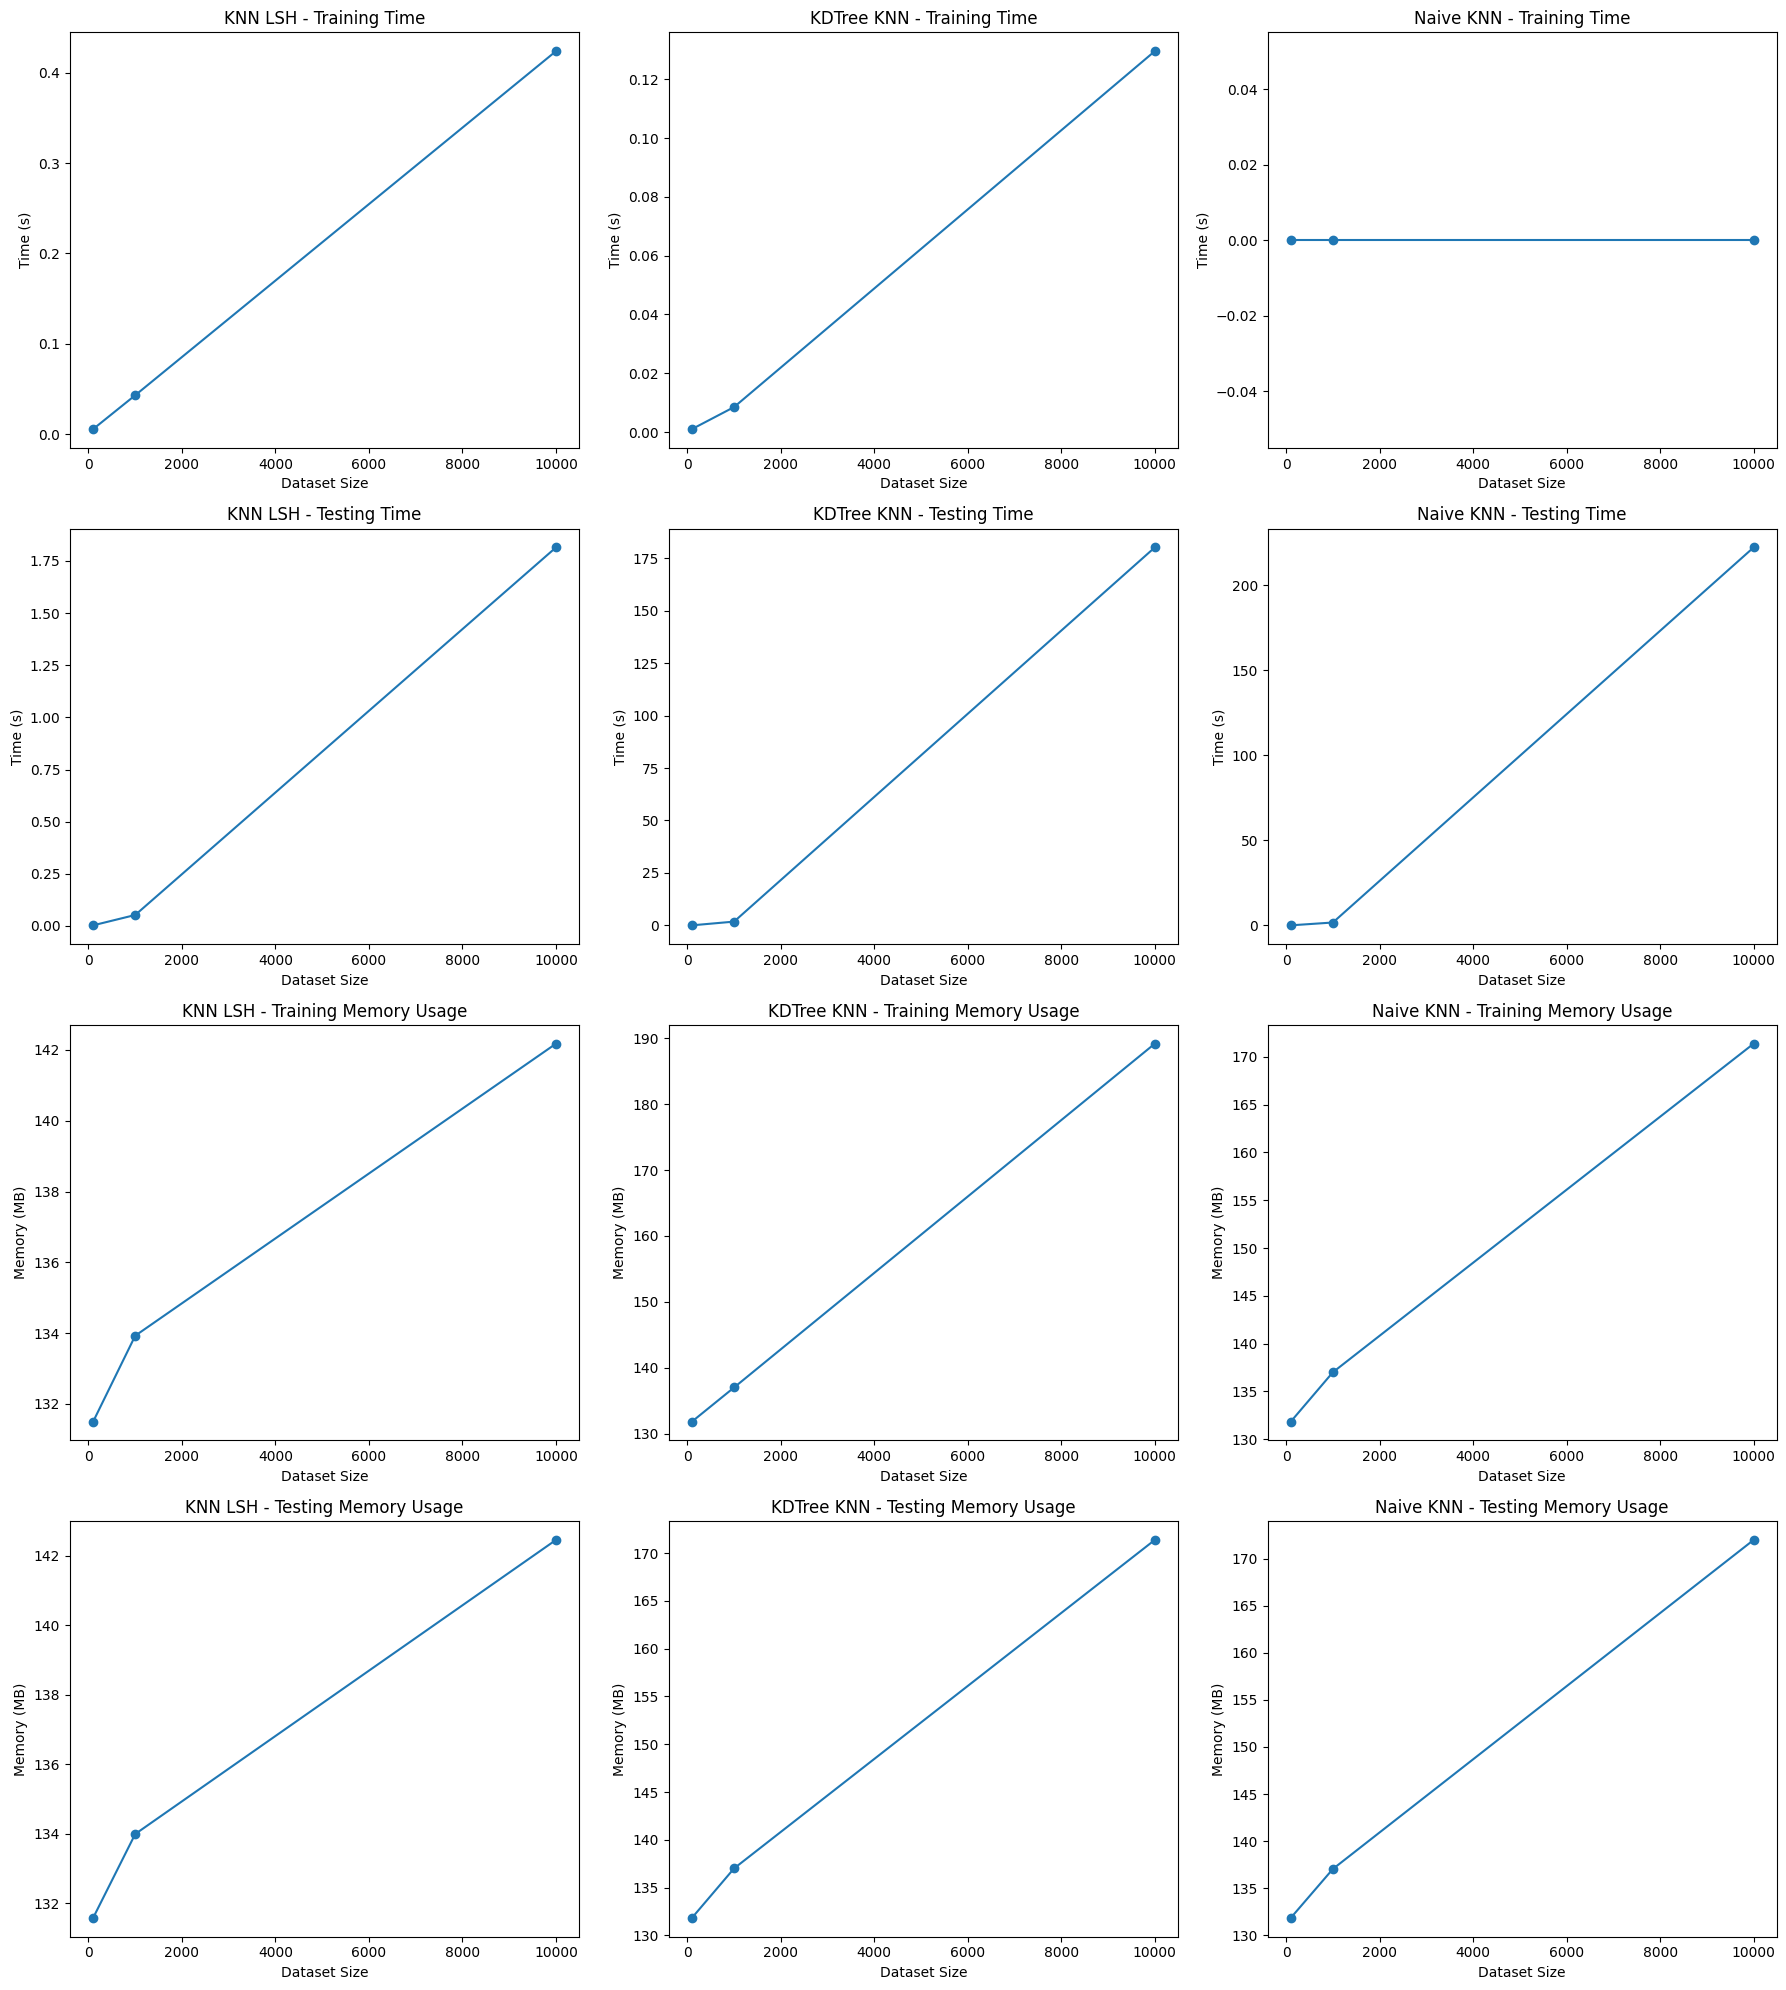

In [6]:
import matplotlib.pyplot as plt

# Set up figure layout for subplots
fig, axs = plt.subplots(4, 3, figsize=(18, 20))  # 4 rows and 3 columns for 12 plots

# Dataset sizes for labels
dataset_sizes = results_df['dataset_size']

# Plot training times for each implementation
axs[0, 0].plot(dataset_sizes, results_df['KNN_LSH_train_time'], marker='o', label='KNN_LSH')
axs[0, 0].set_title("KNN LSH - Training Time")
axs[0, 0].set_xlabel("Dataset Size")
axs[0, 0].set_ylabel("Time (s)")

axs[0, 1].plot(dataset_sizes, results_df['KNN_KDTree_train_time'], marker='o', label='KDTree KNN')
axs[0, 1].set_title("KDTree KNN - Training Time")
axs[0, 1].set_xlabel("Dataset Size")
axs[0, 1].set_ylabel("Time (s)")

axs[0, 2].plot(dataset_sizes, results_df['NaiveKNN_train_time'], marker='o', label='Naive KNN')
axs[0, 2].set_title("Naive KNN - Training Time")
axs[0, 2].set_xlabel("Dataset Size")
axs[0, 2].set_ylabel("Time (s)")

# Plot testing times for each implementation
axs[1, 0].plot(dataset_sizes, results_df['KNN_LSH_test_time'], marker='o', label='KNN_LSH')
axs[1, 0].set_title("KNN LSH - Testing Time")
axs[1, 0].set_xlabel("Dataset Size")
axs[1, 0].set_ylabel("Time (s)")

axs[1, 1].plot(dataset_sizes, results_df['KNN_KDTree_test_time'], marker='o', label='KDTree KNN')
axs[1, 1].set_title("KDTree KNN - Testing Time")
axs[1, 1].set_xlabel("Dataset Size")
axs[1, 1].set_ylabel("Time (s)")

axs[1, 2].plot(dataset_sizes, results_df['NaiveKNN_test_time'], marker='o', label='Naive KNN')
axs[1, 2].set_title("Naive KNN - Testing Time")
axs[1, 2].set_xlabel("Dataset Size")
axs[1, 2].set_ylabel("Time (s)")

# Plot memory usage during training for each implementation
axs[2, 0].plot(dataset_sizes, results_df['KNN_LSH_train_memory'], marker='o', label='KNN_LSH')
axs[2, 0].set_title("KNN LSH - Training Memory Usage")
axs[2, 0].set_xlabel("Dataset Size")
axs[2, 0].set_ylabel("Memory (MB)")

axs[2, 1].plot(dataset_sizes, results_df['KNN_KDTree_train_memory'], marker='o', label='KDTree KNN')
axs[2, 1].set_title("KDTree KNN - Training Memory Usage")
axs[2, 1].set_xlabel("Dataset Size")
axs[2, 1].set_ylabel("Memory (MB)")

axs[2, 2].plot(dataset_sizes, results_df['NaiveKNN_train_memory'], marker='o', label='Naive KNN')
axs[2, 2].set_title("Naive KNN - Training Memory Usage")
axs[2, 2].set_xlabel("Dataset Size")
axs[2, 2].set_ylabel("Memory (MB)")

# Plot memory usage during testing for each implementation
axs[3, 0].plot(dataset_sizes, results_df['KNN_LSH_test_memory'], marker='o', label='KNN_LSH')
axs[3, 0].set_title("KNN LSH - Testing Memory Usage")
axs[3, 0].set_xlabel("Dataset Size")
axs[3, 0].set_ylabel("Memory (MB)")

axs[3, 1].plot(dataset_sizes, results_df['KNN_KDTree_test_memory'], marker='o', label='KDTree KNN')
axs[3, 1].set_title("KDTree KNN - Testing Memory Usage")
axs[3, 1].set_xlabel("Dataset Size")
axs[3, 1].set_ylabel("Memory (MB)")

axs[3, 2].plot(dataset_sizes, results_df['NaiveKNN_test_memory'], marker='o', label='Naive KNN')
axs[3, 2].set_title("Naive KNN - Testing Memory Usage")
axs[3, 2].set_xlabel("Dataset Size")
axs[3, 2].set_ylabel("Memory (MB)")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


1. Training Time

	- LSH-based KNN: Training time increases significantly as dataset size and dimensionality grow (from 0.013 seconds to 1.495 seconds). This is due to the need to build multiple hash tables based on random projections, which grows with the number of dimensions and data points.
	- KD-Tree-based KNN: The KD-Tree has relatively faster training times than LSH, especially in lower dimensions. However, the KD-Tree's efficiency deteriorates with higher dimensions, as seen in the substantial time increase from 0.049 to 0.262 seconds.
	- Naive KNN: Since this technique simply stores data without additional structures, its training time is near zero and remains the most consistent.
	
2. Testing Time

	- LSH-based KNN: Testing time increases with both dataset size and dimensionality but remains efficient for moderate dimensions (e.g., 0.157 seconds for 1000 samples in 20D). For high-dimensional datasets, however, LSH's testing time grows considerably due to the need for exact distance calculations within retrieved candidates.
	- KD-Tree-based KNN: The KD-Tree is fast at low dimensions but becomes significantly slower in high-dimensional data (from 0.074 to 208.054 seconds). This drop is due to the "curse of dimensionality," which reduces the tree's partitioning efficiency.
	- Naive KNN: Testing time scales linearly with dataset size, as each query requires comparing distances to all points. This leads to drastic increases in high dimensions and large datasets, peaking at 120.76 seconds for 10,000 samples in 30D.
	
3. Memory Usage

	- LSH-based KNN: The memory usage slightly increases with dataset size and dimensionality due to the hash tables and random projections. However, LSH maintains relatively low memory usage across datasets compared to KD-Tree and Naive KNN, thanks to its hashing-based structure.
	
	- KD-Tree-based KNN: Memory usage is higher for the KD-Tree, especially as dimensionality increases, as the tree structure requires storage for each split. This effect is visible in the significant increase from ~221 MB to ~247 MB as dimensions rise.

	- Naive KNN: Memory usage increases linearly with dataset size and dimension since no structures are used to optimize memory, and the entire dataset must be retained.	
	
Hence,
1. LSH: performs well with moderate dimensions and larger datasets due to hashing, making it faster at high scales than the other methods. However, testing time becomes more costly with very high dimensions. Hence prefered for high dimension data.

2. KD-Tree: s effective at low-dimensional data but quickly becomes inefficient in higher dimensions due to the curse of dimensionality.Hence prefered for low dimension data.

3. Naive KNN: has the highest testing time for large, high-dimensional datasets, but it uses minimium memory with minimal preprocessing. Hence prefered for small dataset and no complexity is expected.


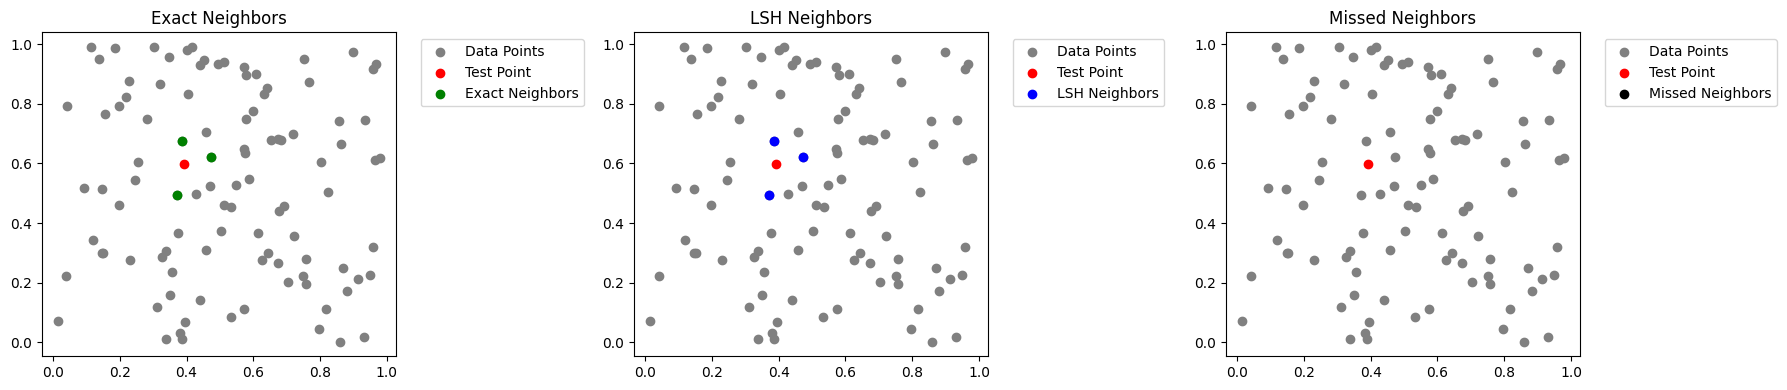

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# Generate a random 2D dataset
np.random.seed(35)
X = np.random.rand(100, 2)  # 100 random points in 2D space
test_point = np.random.rand(1, 2)  # Generate a random test point

# Parameters
k = 3  # Number of neighbors
lsh_knn = LSH_KNN(n_hash_tables=3, hash_size=3, k=k)
lsh_knn.fit(X, np.zeros(X.shape[0]))  # Dummy labels

# Function to find exact k-nearest neighbors using brute-force search
def exact_knn(X, test_point, k):
    distances = [(i, euclidean(test_point, x)) for i, x in enumerate(X)]
    distances.sort(key=lambda x: x[1])  # Sort by distance
    return [idx for idx, dist in distances[:k]]  # Return indices of exact neighbors

# Find neighbors using LSH
lsh_neighbors = lsh_knn._get_nearest_neighbors(test_point[0])

# Find exact neighbors using brute-force
exact_neighbors = exact_knn(X, test_point[0], k)

# Calculate missed neighbors
missed_neighbors = set(exact_neighbors) - set(lsh_neighbors)

# Plotting

# First plot: Exact neighbors
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data Points')
plt.scatter(test_point[0, 0], test_point[0, 1], color='red', label='Test Point')
plt.scatter(X[exact_neighbors, 0], X[exact_neighbors, 1], color='green', label='Exact Neighbors')
plt.title("Exact Neighbors")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Second plot: LSH neighbors
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data Points')
plt.scatter(test_point[0, 0], test_point[0, 1], color='red', label='Test Point')
plt.scatter(X[lsh_neighbors, 0], X[lsh_neighbors, 1], color='blue', label='LSH Neighbors')
plt.title("LSH Neighbors")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Third plot: Missed neighbors
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data Points')
plt.scatter(test_point[0, 0], test_point[0, 1], color='red', label='Test Point')
plt.scatter(X[list(missed_neighbors), 0], X[list(missed_neighbors), 1], color='black', label='Missed Neighbors')
plt.title("Missed Neighbors")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Observation:

- We tried changing the random seed and still couldn't find an instance where we can get a missed point. KNN with LSH was performing as good as the Naive KNN.
- We suspect that the random hyperplanes that are getting created are such that all the datapoints are coming under one single bucket, therefore overall there is no effect of using LSH.

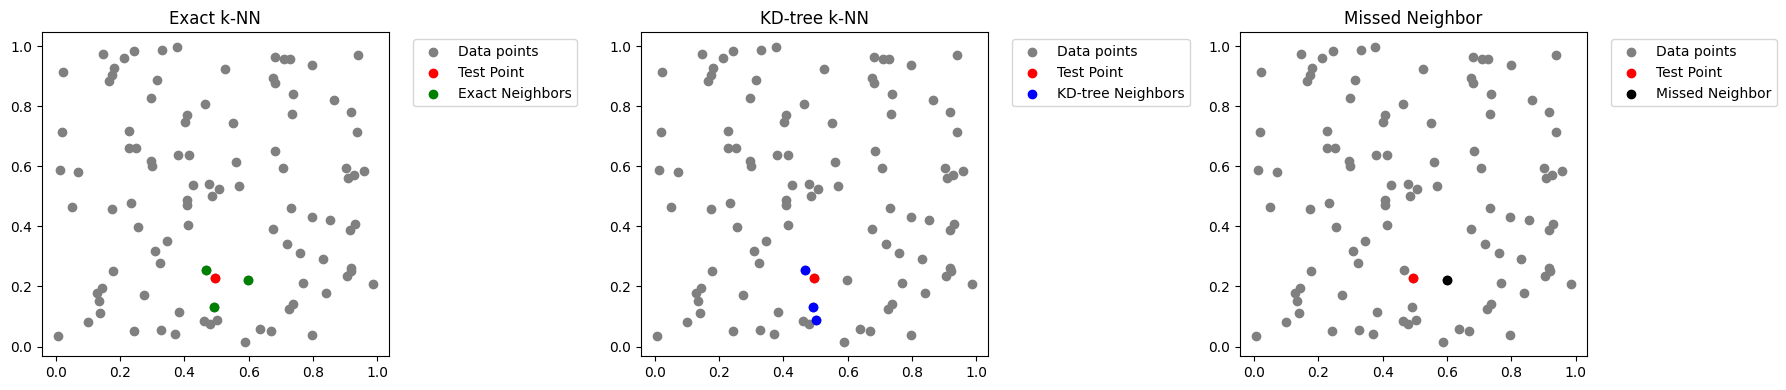

In [ ]:
from scipy.spatial.distance import cdist
# Generate a random 2D dataset
np.random.seed(50)
X = np.random.rand(100, 2)  # 100 points in 2D
y = np.random.choice([0, 1], size=100)

# Fit the KD-tree model
knn = KDTreeKNN(k=3)
knn.fit(X, y)
test_point = X[0]

kd_tree_neighbors = knn.predict([test_point])[0]

distances = cdist([test_point], X, 'euclidean').flatten()
sorted_indices = np.argsort(distances)
exact_neighbors = X[sorted_indices[1:4]]

# Find the missed neighbor (difference between exact and KD-tree neighbors)
missed_neighbors = list(set(tuple(row) for row in exact_neighbors) - set(tuple(row) for row in kd_tree_neighbors))

# Function to plot the results
def plot_neighbors(X, test_point, exact_neighbors, kd_tree_neighbors, missed_neighbor=None):
    plt.figure(figsize=(18, 4))

    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c='gray', label='Data points')
    plt.scatter(test_point[0], test_point[1], color='red', label='Test Point')
    plt.scatter(exact_neighbors[:, 0], exact_neighbors[:, 1], color='green', label='Exact Neighbors')
    plt.title('Exact k-NN')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(132)
    plt.scatter(X[:, 0], X[:, 1], c='gray', label='Data points')
    plt.scatter(test_point[0], test_point[1], color='red', label='Test Point')
    plt.scatter(np.array(kd_tree_neighbors)[:, 0], np.array(kd_tree_neighbors)[:, 1], color='blue', label='KD-tree Neighbors')
    plt.title('KD-tree k-NN')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(133)
    plt.scatter(X[:, 0], X[:, 1], c='gray', label='Data points')
    plt.scatter(test_point[0], test_point[1], color='red', label='Test Point')
    if missed_neighbor is not None:
        plt.scatter(missed_neighbor[0], missed_neighbor[1], color='black', label='Missed Neighbor')
    plt.title('Missed Neighbor')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the neighbors
plot_neighbors(X, test_point, exact_neighbors, kd_tree_neighbors, missed_neighbors[0] if missed_neighbors else None)

### Observation:

- We can see that one of the K neighbours is getting missed due to the approximation.

In [16]:
import math
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class KDTreeNode:
    """Node of a KD-tree."""
    def __init__(self, point, axis, left=None, right=None):
        self.point = point  # The point stored at this node
        self.axis = axis   # Axis of splitting
        self.left = left    # Left subtree
        self.right = right  # Right subtree

class KDTreeKNN:
    def __init__(self, k=3, max_leaf_size=10):
        self.k = k
        self.root = None
        self.max_leaf_size = max_leaf_size
        self.split_lines = []  # List to store lines used for splitting

    def _build_tree(self, points, depth=0):
        """Recursive function to build KD-tree with visualization."""
        if len(points) == 0:
            return None

        # Select axis based on depth
        axis = depth % points.shape[1]

        # Sort points and choose median
        points = points[points[:, axis].argsort()]
        median_idx = len(points) // 2

        # Check if splitting needed (consider max_leaf_size)
        if len(points) <= self.max_leaf_size:
            return KDTreeNode(point=points[median_idx], axis=axis)

        # Create node and recursively construct subtrees
        node = KDTreeNode(point=points[median_idx], axis=axis)
        self.split_lines.append((axis, points[median_idx, axis]))  # Store axis and value
        node.left = self._build_tree(points[:median_idx], depth + 1)
        node.right = self._build_tree(points[median_idx + 1:], depth + 1)
        return node

    def _get_split_line(self, points, axis, median_idx):
        """Get line equation for splitting based on median point."""
        if axis == 0:
            x = points[median_idx, 0]
            return lambda y: y
        else:
            y = points[median_idx, 1]
            return lambda x: x

    def fit(self, X, y):
        """Fit KD-tree to the data."""
        self.root = self._build_tree(X)
        self.data = X
        self.labels = y

    def _distance(self, point1, point2):
        """Compute Euclidean distance between two points."""
        return math.sqrt(np.sum((point1 - point2) ** 2))

    def _knn_search(self, node, point, k_neighbors, depth=0):
        """Recursive function to search for k-nearest neighbors."""
        if node is None:
            return

        # Skip the test point itself
        if np.array_equal(node.point, point):
            return

        # Compute distance to current node
        dist = self._distance(point, node.point)

        # Update k nearest neighbors
        if len(k_neighbors) < self.k or dist < k_neighbors[-1][1]:
            k_neighbors.append((node.point, dist))
            k_neighbors.sort(key=lambda x: x[1])  # Sort by distance
            if len(k_neighbors) > self.k:
                k_neighbors.pop()  # Keep only k neighbors

        # Determine which branch to search
        axis = node.axis
        diff = point[axis] - node.point[axis]
        next_branch = node.left if diff < 0 else node.right
        opposite_branch = node.right if diff < 0 else node.left

        # Search next branch
        self._knn_search(next_branch, point, k_neighbors, depth + 1)

        # Search opposite branch if necessary
        if len(k_neighbors) < self.k or abs(diff) < k_neighbors[-1][1]:
            self._knn_search(opposite_branch, point, k_neighbors, depth + 1)

    def predict(self, X):
        """Predict k-nearest neighbors for each point in X."""
        neighbors = []
        for x in X:
            k_neighbors = []
            self._knn_search(self.root, x, k_neighbors)
            neighbors.append([neighbor[0] for neighbor in k_neighbors])
        return neighbors

    def visualize_tree(self, X, y, test_point, k=3):
        """Visualize the KD-tree and k-nearest neighbors."""
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data points')

        # Plot split lines
        for line_params in self.split_lines:
            axis, value = line_params
            if axis == 0:
                plt.axvline(x=value, color='red', linestyle='--')
            else:
                plt.axhline(y=value, color='red', linestyle='--')

        # Find k nearest neighbors using KD-tree
        knn_kd = self.predict([test_point])[0]
        knn_kd = np.array(knn_kd)  # Convert to NumPy array

        # Find exact k nearest neighbors
        distances = cdist([test_point], X)
        knn_exact = X[distances.argsort()[0, :k]]

        # Plot test point, KD-tree neighbors, and exact neighbors
        plt.scatter(test_point[0], test_point[1], color='blue', label='Test point')
        plt.scatter(knn_kd[:, 0], knn_kd[:, 1], color='green', label='KD-tree neighbors')
        plt.scatter(knn_exact[:, 0], knn_exact[:, 1], color='orange', label='Exact neighbors')

        # Plot missed neighbors (if any)
        missed_neighbors = np.setdiff1d(knn_exact, knn_kd, assume_unique=True)
        if np.ndim(missed_neighbors) == 1:
            plt.scatter(missed_neighbors[0], missed_neighbors[1], color='black', label='Missed neighbors')
        else:
            plt.scatter(missed_neighbors[:, 0], missed_neighbors[:, 1], color='black', label='Missed neighbors')

        plt.legend()
        plt.show()

In [17]:
import numpy as np
# Generate random 2D dataset
np.random.seed(50)
X = np.random.rand(100, 2)  # 100 points in 2D
y = np.random.choice([0, 1], size=100)  # Labels (not used in KD-tree here)

In [18]:
knn_tree = KDTreeKNN(k=3, max_leaf_size=10)

In [19]:
knn_tree.fit(X, y)

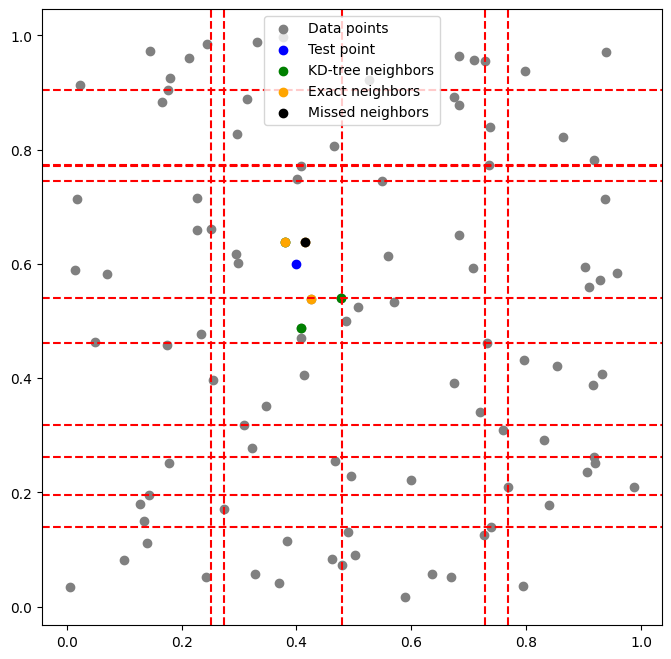

In [20]:
np.random.seed(50)
X = np.random.rand(100, 2)
y = np.random.randint(0, 2, 100)

# Initialize the KD-tree
knn_tree = KDTreeKNN(k=3, max_leaf_size=10)

# Fit the KD-tree to the data
knn_tree.fit(X, y)

# Choose a test point
test_point = [0.4, 0.6]

# Visualize the KD-tree and nearest neighbors
knn_tree.visualize_tree(X, y, test_point)

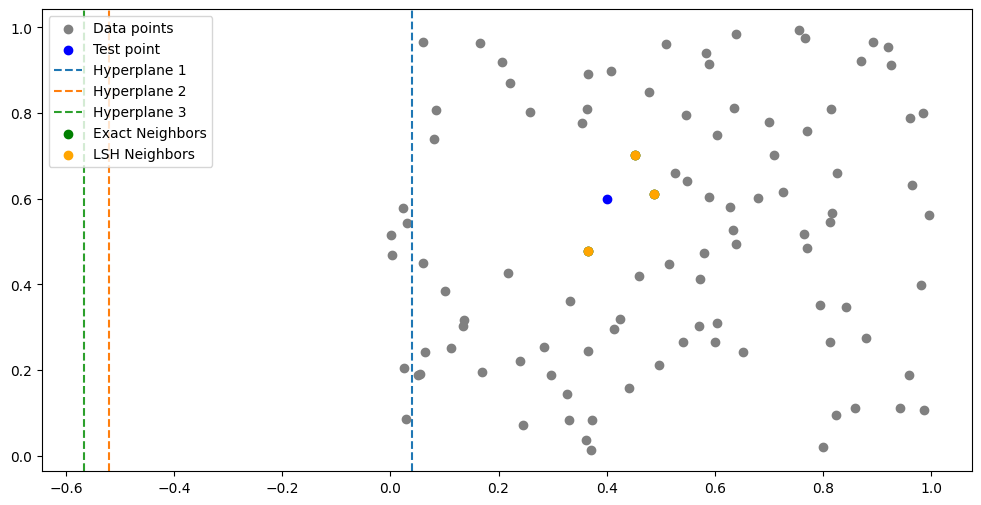

In [21]:
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

class LSH_KNN:
    def __init__(self, n_hash_tables=5, hash_size=10, k=3):
        self.n_hash_tables = n_hash_tables  # Number of hash tables
        self.hash_size = hash_size          # Number of bits in the hash
        self.k = k                          # Number of neighbors
        self.tables = [defaultdict(list) for _ in range(n_hash_tables)]  # Hash tables
        self.projections = []               # Random projections for hash functions

    def _hash_function(self, v, projection):
        """Create a binary hash for vector v using random projection."""
        return tuple((v @ projection > 0).astype(int))  # Binary hash as tuple

    def _generate_projections(self, dim):
        """Generate random projections for each hash table."""
        self.projections = [np.random.randn(dim, self.hash_size) for _ in range(self.n_hash_tables)]

    def fit(self, X, y):
        """Fit LSH to the data."""
        n_samples, n_features = X.shape
        self._generate_projections(n_features)

        # Create hash tables
        for idx, x in enumerate(X):
            for i in range(self.n_hash_tables):
                projection = self.projections[i]
                hash_key = self._hash_function(x, projection)
                self.tables[i][hash_key].append(idx)  # Store index of data point

        self.data = X 
        self.labels = y

    def _get_candidates(self, x):
        """Get candidate points for a query point x by checking all hash tables."""
        candidates = set()
        for i in range(self.n_hash_tables):
            projection = self.projections[i]
            hash_key = self._hash_function(x, projection)
            candidates.update(self.tables[i][hash_key])  # Collect indices from each table
        return list(candidates)

    def _get_nearest_neighbors(self, x):
        """Compute nearest neighbors from candidates."""
        candidates = self._get_candidates(x)
        if len(candidates) == 0:
            return [] 

        distances = [(i, euclidean(x, self.data[i])) for i in candidates]
        distances.sort(key=lambda x: x[1])  # Sort by distance

        # Return the top-k closest points
        return [idx for idx, dist in distances[:self.k]]

    def predict(self, X):
        """Predict neighbors for each point in X."""
        neighbors = [self._get_nearest_neighbors(x) for x in X]
        return neighbors

    def visualize_hash_tables(self, X, test_point, labels=None):
        """Visualize data points, projections, and hash table buckets."""
        plt.figure(figsize=(12, 6))
        plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data points')

        # Draw test point
        plt.scatter(test_point[0], test_point[1], color='blue', label='Test point')

        # Visualize projections and hash table buckets
        for i, projection in enumerate(self.projections):
            # Project data points
            projected_X = X.dot(projection)

            # Visualize hyperplane
            w = projection[:, 0] 
            b = (w @ test_point)
            plt.axvline(x=b, color=f'C{i}', linestyle='--', label=f'Hyperplane {i+1}')

            # Identify data points in each bucket based on their projections
            bucket_data = []
            for key, indices in self.tables[i].items():
                bucket_data.append([X[idx] for idx in indices])

        # Find exact nearest neighbors
        distances = cdist([test_point], X)
        knn_exact = X[distances.argsort()[0, :self.k]]

        # Find LSH nearest neighbors
        knn_lsh = self.predict([test_point])[0]
        knn_lsh = X[knn_lsh]

        # Calculate missed neighbors
        knn_exact_tuples = tuple(map(tuple, knn_exact))  # Convert to tuples
        knn_lsh_tuples = tuple(map(tuple, knn_lsh))
        missed_neighbors = set(knn_exact_tuples).difference(set(knn_lsh_tuples))

        # Convert back to NumPy array for plotting
        missed_neighbors = np.array(list(missed_neighbors))

        # Plot exact and LSH neighbors
        plt.scatter(knn_exact[:, 0], knn_exact[:, 1], color='green', label='Exact Neighbors')
        plt.scatter(knn_lsh[:, 0], knn_lsh[:, 1], color='orange', label='LSH Neighbors')

        # Highlight missed neighbors
        if missed_neighbors.size > 0:
            plt.scatter(missed_neighbors[:, 0], missed_neighbors[:, 1], color='red', label='Missed Neighbors')

        plt.legend()
        plt.show()

np.random.seed(5)
X = np.random.rand(100, 2)
y = np.random.randint(0, 2, 100)

lsh = LSH_KNN(n_hash_tables=3, hash_size=10, k=3)
lsh.fit(X, y)


test_point = [0.4, 0.6]
lsh.visualize_hash_tables(X, test_point)